In [85]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torchviz import make_dot
from tqdm import tqdm
import wandb

In [86]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)# cudaが利用可能だと0

cuda:0


In [87]:
wandb.init(project="mnist_test")
wandb.config = {
  "learning_rate": 0.05,
  "epochs": 100,
  "batch_size": 128*2
}

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
test_loss,0.07201
train_loss,0.0263


In [88]:
# 最終的なデータセットの定義
data_root = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])
train_set = datasets.MNIST(
    root = data_root, train=True, download=False, transform=transform
)
test_set = datasets.MNIST(
    root = data_root, train=False, download=False, transform=transform
)

In [89]:
from torch.utils.data import DataLoader
batch_size = wandb.config["batch_size"]

train_loader = DataLoader(
    train_set, batch_size = batch_size,
    shuffle = True
)
test_loader = DataLoader(
    test_set, batch_size = batch_size,
    shuffle = False
)

In [90]:
# 入出力、隠れ層の設定
image, label = train_set[0]
n_input = image.shape[0]
for images, labels in train_loader:
    break
n_output = len(set(list(labels.data.numpy())))
n_hidden = 128

In [91]:
# モデルの定義
# 784入力10出力２隠れ層のNNモデル
class Net1(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        # 隠れ層1
        self.l1 = nn.Linear(n_input, n_hidden)
        # 出力層
        self.l2 = nn.Linear(n_hidden, n_output)
        # ReLU
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l3(x2)
        return x3

# NN層の定義
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# 学習率
lr = wandb.config["learning_rate"]
# モデル初期化
net = Net1(n_input, n_output, n_hidden).to(device)
print(net)

Net1(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [92]:
# モデルの定義
# 784入力10出力２隠れ層のNNモデル
class Net2(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        # 隠れ層1
        self.l1 = nn.Linear(n_input, n_hidden)
        # 隠れ層2
        self.l2 = nn.Linear(n_hidden, n_hidden)
        # 出力層
        self.l3 = nn.Linear(n_hidden, n_output)
        # ReLU
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        x4 = self.relu(x3)
        x5 = self.l3(x4)
        return x5

# NN層の定義
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# 学習率
lr = wandb.config["learning_rate"]
# モデル初期化
net = Net2(n_input, n_output, n_hidden).to(device)
print(net)

Net2(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [93]:
# 損失関数：交差エントロピー関数
criterion = nn.CrossEntropyLoss()
# 最適化関数
optimizer = optim.SGD(net.parameters(), lr=lr)
# 繰り返し回数
num_epochs = wandb.config["epochs"]
# 評価関数結果記録用
history = np.zeros((0,5))

In [94]:
# 繰り返し計算メインループ
for epoch in range(num_epochs):
    train_acc, train_loss = 0, 0
    test_acc, test_loss = 0, 0
    n_train, n_test = 0, 0

    # 訓練フェーズ
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)
        # GPUへ転送
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 勾配の初期化
        optimizer.zero_grad()
        # 予測計算
        outputs = net(inputs)
        # 損失計算
        loss = criterion(outputs, labels)
        # 勾配計算
        loss.backward()
        # パラメータ修正
        optimizer.step()
        # 予測ラベル導出
        predicted = torch.max(outputs, 1)[1]
        # 損失と精度の計算
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item() 

    # 予測フェーズ
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)
        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        # 予測計算
        outputs_test = net(inputs_test)

        # 損失関数
        loss_test = criterion(outputs_test, labels_test)


        # 予測データ導出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 損失と制度の計算
        test_loss += loss_test.item()
        test_acc += (predicted_test == labels_test).sum().item()

    # 評価値の算出・記録
    train_acc = train_acc / n_train
    test_acc = test_acc / n_test
    train_loss = train_loss * batch_size / n_train
    test_loss = test_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {test_loss:.5f}, val_acc: {test_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, test_loss, test_acc])
    history = np.vstack((history, item))
    wandb.log({"epoch": epoch, "train_loss": train_loss, "test_loss": test_loss})
print(f'初期状態：損失：{history[0,3]:.5f}  精度：{history[0,4]:.5f}')
print(f'最終状態：損失：{history[-1,3]:.5f}  精度：{history[-1,4]:.5f}')

100%|██████████| 235/235 [00:02<00:00, 101.94it/s]


Epoch [1/100], loss: 0.93611 acc: 0.72617 val_loss: 0.44622, val_acc: 0.85780


100%|██████████| 235/235 [00:02<00:00, 103.10it/s]


Epoch [2/100], loss: 0.36023 acc: 0.89328 val_loss: 0.31950, val_acc: 0.90500


100%|██████████| 235/235 [00:02<00:00, 102.94it/s]


Epoch [3/100], loss: 0.29920 acc: 0.91120 val_loss: 0.28742, val_acc: 0.91630


100%|██████████| 235/235 [00:02<00:00, 101.02it/s]


Epoch [4/100], loss: 0.26168 acc: 0.92187 val_loss: 0.25216, val_acc: 0.92630


100%|██████████| 235/235 [00:02<00:00, 102.74it/s]


Epoch [5/100], loss: 0.23138 acc: 0.93230 val_loss: 0.22376, val_acc: 0.93750


100%|██████████| 235/235 [00:02<00:00, 103.06it/s]


Epoch [6/100], loss: 0.20511 acc: 0.93975 val_loss: 0.19811, val_acc: 0.93990


100%|██████████| 235/235 [00:02<00:00, 100.84it/s]


Epoch [7/100], loss: 0.18603 acc: 0.94555 val_loss: 0.19636, val_acc: 0.93930


100%|██████████| 235/235 [00:02<00:00, 103.92it/s]


Epoch [8/100], loss: 0.16955 acc: 0.94975 val_loss: 0.18647, val_acc: 0.94270


100%|██████████| 235/235 [00:02<00:00, 102.67it/s]


Epoch [9/100], loss: 0.15553 acc: 0.95385 val_loss: 0.15557, val_acc: 0.95230


100%|██████████| 235/235 [00:02<00:00, 103.81it/s]


Epoch [10/100], loss: 0.14302 acc: 0.95767 val_loss: 0.14092, val_acc: 0.95830


100%|██████████| 235/235 [00:02<00:00, 101.10it/s]


Epoch [11/100], loss: 0.13280 acc: 0.96047 val_loss: 0.14859, val_acc: 0.95360


100%|██████████| 235/235 [00:02<00:00, 102.76it/s]


Epoch [12/100], loss: 0.12352 acc: 0.96392 val_loss: 0.13311, val_acc: 0.95870


100%|██████████| 235/235 [00:02<00:00, 102.21it/s]


Epoch [13/100], loss: 0.11546 acc: 0.96635 val_loss: 0.13038, val_acc: 0.96040


100%|██████████| 235/235 [00:02<00:00, 101.17it/s]


Epoch [14/100], loss: 0.10832 acc: 0.96798 val_loss: 0.13111, val_acc: 0.95930


100%|██████████| 235/235 [00:02<00:00, 101.69it/s]


Epoch [15/100], loss: 0.10129 acc: 0.97058 val_loss: 0.11457, val_acc: 0.96440


100%|██████████| 235/235 [00:02<00:00, 101.60it/s]


Epoch [16/100], loss: 0.09535 acc: 0.97208 val_loss: 0.11112, val_acc: 0.96670


100%|██████████| 235/235 [00:02<00:00, 99.23it/s] 


Epoch [17/100], loss: 0.09013 acc: 0.97338 val_loss: 0.10355, val_acc: 0.96870


100%|██████████| 235/235 [00:02<00:00, 102.55it/s]


Epoch [18/100], loss: 0.08640 acc: 0.97473 val_loss: 0.13490, val_acc: 0.95870


100%|██████████| 235/235 [00:02<00:00, 101.38it/s]


Epoch [19/100], loss: 0.08080 acc: 0.97623 val_loss: 0.10460, val_acc: 0.96720


100%|██████████| 235/235 [00:02<00:00, 102.60it/s]


Epoch [20/100], loss: 0.07654 acc: 0.97713 val_loss: 0.09801, val_acc: 0.96990


100%|██████████| 235/235 [00:02<00:00, 102.75it/s]


Epoch [21/100], loss: 0.07292 acc: 0.97845 val_loss: 0.15458, val_acc: 0.94650


100%|██████████| 235/235 [00:02<00:00, 104.27it/s]


Epoch [22/100], loss: 0.06944 acc: 0.97957 val_loss: 0.10635, val_acc: 0.96760


100%|██████████| 235/235 [00:02<00:00, 103.07it/s]


Epoch [23/100], loss: 0.06571 acc: 0.98098 val_loss: 0.09205, val_acc: 0.97120


100%|██████████| 235/235 [00:02<00:00, 100.71it/s]


Epoch [24/100], loss: 0.06297 acc: 0.98118 val_loss: 0.08316, val_acc: 0.97320


100%|██████████| 235/235 [00:02<00:00, 104.11it/s]


Epoch [25/100], loss: 0.05964 acc: 0.98288 val_loss: 0.08222, val_acc: 0.97490


100%|██████████| 235/235 [00:02<00:00, 102.82it/s]


Epoch [26/100], loss: 0.05664 acc: 0.98293 val_loss: 0.08244, val_acc: 0.97380


100%|██████████| 235/235 [00:02<00:00, 102.96it/s]


Epoch [27/100], loss: 0.05442 acc: 0.98447 val_loss: 0.07858, val_acc: 0.97560


100%|██████████| 235/235 [00:02<00:00, 102.63it/s]


Epoch [28/100], loss: 0.05183 acc: 0.98508 val_loss: 0.08785, val_acc: 0.97170


100%|██████████| 235/235 [00:02<00:00, 103.36it/s]


Epoch [29/100], loss: 0.05038 acc: 0.98557 val_loss: 0.08625, val_acc: 0.97370


100%|██████████| 235/235 [00:02<00:00, 102.15it/s]


Epoch [30/100], loss: 0.04825 acc: 0.98657 val_loss: 0.09713, val_acc: 0.96860


100%|██████████| 235/235 [00:02<00:00, 100.85it/s]


Epoch [31/100], loss: 0.04548 acc: 0.98718 val_loss: 0.08829, val_acc: 0.97090


100%|██████████| 235/235 [00:02<00:00, 103.05it/s]


Epoch [32/100], loss: 0.04374 acc: 0.98815 val_loss: 0.10584, val_acc: 0.96770


100%|██████████| 235/235 [00:02<00:00, 103.06it/s]


Epoch [33/100], loss: 0.04253 acc: 0.98847 val_loss: 0.14338, val_acc: 0.95220


100%|██████████| 235/235 [00:02<00:00, 101.46it/s]


Epoch [34/100], loss: 0.04024 acc: 0.98903 val_loss: 0.08148, val_acc: 0.97500


100%|██████████| 235/235 [00:02<00:00, 103.86it/s]


Epoch [35/100], loss: 0.03955 acc: 0.98902 val_loss: 0.08660, val_acc: 0.97340


100%|██████████| 235/235 [00:02<00:00, 104.18it/s]


Epoch [36/100], loss: 0.03740 acc: 0.98988 val_loss: 0.07303, val_acc: 0.97720


100%|██████████| 235/235 [00:02<00:00, 103.61it/s]


Epoch [37/100], loss: 0.03608 acc: 0.99018 val_loss: 0.12240, val_acc: 0.96290


100%|██████████| 235/235 [00:02<00:00, 101.97it/s]


Epoch [38/100], loss: 0.03411 acc: 0.99082 val_loss: 0.07322, val_acc: 0.97760


100%|██████████| 235/235 [00:02<00:00, 104.61it/s]


Epoch [39/100], loss: 0.03272 acc: 0.99112 val_loss: 0.07224, val_acc: 0.97780


100%|██████████| 235/235 [00:02<00:00, 103.38it/s]


Epoch [40/100], loss: 0.04526 acc: 0.98902 val_loss: 0.07716, val_acc: 0.97590


100%|██████████| 235/235 [00:02<00:00, 99.97it/s] 


Epoch [41/100], loss: 0.03060 acc: 0.99218 val_loss: 0.07541, val_acc: 0.97600


100%|██████████| 235/235 [00:02<00:00, 102.48it/s]


Epoch [42/100], loss: 0.02910 acc: 0.99247 val_loss: 0.08096, val_acc: 0.97510


100%|██████████| 235/235 [00:02<00:00, 104.25it/s]


Epoch [43/100], loss: 0.02805 acc: 0.99292 val_loss: 0.07192, val_acc: 0.97750


100%|██████████| 235/235 [00:02<00:00, 103.01it/s]


Epoch [44/100], loss: 0.02740 acc: 0.99280 val_loss: 0.08604, val_acc: 0.97430


100%|██████████| 235/235 [00:02<00:00, 102.79it/s]


Epoch [45/100], loss: 0.02631 acc: 0.99337 val_loss: 0.06960, val_acc: 0.97890


100%|██████████| 235/235 [00:02<00:00, 103.37it/s]


Epoch [46/100], loss: 0.02483 acc: 0.99388 val_loss: 0.07081, val_acc: 0.97840


100%|██████████| 235/235 [00:02<00:00, 102.75it/s]


Epoch [47/100], loss: 0.02442 acc: 0.99410 val_loss: 0.07451, val_acc: 0.97780


100%|██████████| 235/235 [00:02<00:00, 100.11it/s]


Epoch [48/100], loss: 0.02322 acc: 0.99440 val_loss: 0.07032, val_acc: 0.97960


100%|██████████| 235/235 [00:02<00:00, 103.57it/s]


Epoch [49/100], loss: 0.02271 acc: 0.99432 val_loss: 0.07211, val_acc: 0.97730


100%|██████████| 235/235 [00:02<00:00, 104.77it/s]


Epoch [50/100], loss: 0.02149 acc: 0.99493 val_loss: 0.06932, val_acc: 0.97960


100%|██████████| 235/235 [00:02<00:00, 102.30it/s]


Epoch [51/100], loss: 0.02022 acc: 0.99553 val_loss: 0.08261, val_acc: 0.97610


100%|██████████| 235/235 [00:02<00:00, 104.53it/s]


Epoch [52/100], loss: 0.01942 acc: 0.99590 val_loss: 0.07141, val_acc: 0.97810


100%|██████████| 235/235 [00:02<00:00, 104.20it/s]


Epoch [53/100], loss: 0.01882 acc: 0.99588 val_loss: 0.07155, val_acc: 0.97850


100%|██████████| 235/235 [00:02<00:00, 103.95it/s]


Epoch [54/100], loss: 0.01819 acc: 0.99588 val_loss: 0.09820, val_acc: 0.97220


100%|██████████| 235/235 [00:02<00:00, 101.71it/s]


Epoch [55/100], loss: 0.01730 acc: 0.99645 val_loss: 0.07271, val_acc: 0.97830


100%|██████████| 235/235 [00:02<00:00, 104.18it/s]


Epoch [56/100], loss: 0.01684 acc: 0.99652 val_loss: 0.07031, val_acc: 0.98010


100%|██████████| 235/235 [00:02<00:00, 103.97it/s]


Epoch [57/100], loss: 0.01585 acc: 0.99658 val_loss: 0.06917, val_acc: 0.97900


100%|██████████| 235/235 [00:02<00:00, 102.03it/s]


Epoch [58/100], loss: 0.01509 acc: 0.99717 val_loss: 0.07172, val_acc: 0.97890


100%|██████████| 235/235 [00:02<00:00, 104.14it/s]


Epoch [59/100], loss: 0.01485 acc: 0.99720 val_loss: 0.13343, val_acc: 0.96080


100%|██████████| 235/235 [00:02<00:00, 102.52it/s]


Epoch [60/100], loss: 0.01436 acc: 0.99720 val_loss: 0.07463, val_acc: 0.97950


100%|██████████| 235/235 [00:02<00:00, 101.75it/s]


Epoch [61/100], loss: 0.01396 acc: 0.99723 val_loss: 0.07222, val_acc: 0.97910


100%|██████████| 235/235 [00:02<00:00, 104.18it/s]


Epoch [62/100], loss: 0.01341 acc: 0.99750 val_loss: 0.07463, val_acc: 0.97850


100%|██████████| 235/235 [00:02<00:00, 104.26it/s]


Epoch [63/100], loss: 0.01300 acc: 0.99763 val_loss: 0.07117, val_acc: 0.98000


100%|██████████| 235/235 [00:02<00:00, 103.32it/s]


Epoch [64/100], loss: 0.01214 acc: 0.99788 val_loss: 0.07446, val_acc: 0.97840


100%|██████████| 235/235 [00:02<00:00, 101.78it/s]


Epoch [65/100], loss: 0.01176 acc: 0.99793 val_loss: 0.07413, val_acc: 0.97920


100%|██████████| 235/235 [00:02<00:00, 104.35it/s]


Epoch [66/100], loss: 0.01142 acc: 0.99813 val_loss: 0.07258, val_acc: 0.97930


100%|██████████| 235/235 [00:02<00:00, 104.26it/s]


Epoch [67/100], loss: 0.01122 acc: 0.99797 val_loss: 0.07317, val_acc: 0.97890


100%|██████████| 235/235 [00:02<00:00, 101.83it/s]


Epoch [68/100], loss: 0.01054 acc: 0.99837 val_loss: 0.07289, val_acc: 0.97870


100%|██████████| 235/235 [00:02<00:00, 105.67it/s]


Epoch [69/100], loss: 0.01033 acc: 0.99825 val_loss: 0.07220, val_acc: 0.97980


100%|██████████| 235/235 [00:02<00:00, 103.54it/s]


Epoch [70/100], loss: 0.00968 acc: 0.99850 val_loss: 0.07272, val_acc: 0.97880


100%|██████████| 235/235 [00:02<00:00, 103.06it/s]


Epoch [71/100], loss: 0.00936 acc: 0.99870 val_loss: 0.07408, val_acc: 0.98040


100%|██████████| 235/235 [00:02<00:00, 102.28it/s]


Epoch [72/100], loss: 0.00911 acc: 0.99865 val_loss: 0.07269, val_acc: 0.97920


100%|██████████| 235/235 [00:02<00:00, 103.65it/s]


Epoch [73/100], loss: 0.00882 acc: 0.99875 val_loss: 0.08029, val_acc: 0.97800


100%|██████████| 235/235 [00:02<00:00, 104.23it/s]


Epoch [74/100], loss: 0.00823 acc: 0.99897 val_loss: 0.07437, val_acc: 0.97910


100%|██████████| 235/235 [00:02<00:00, 101.42it/s]


Epoch [75/100], loss: 0.00815 acc: 0.99905 val_loss: 0.07387, val_acc: 0.97910


100%|██████████| 235/235 [00:02<00:00, 103.73it/s]


Epoch [76/100], loss: 0.00856 acc: 0.99872 val_loss: 0.07284, val_acc: 0.97940


100%|██████████| 235/235 [00:02<00:00, 101.75it/s]


Epoch [77/100], loss: 0.00740 acc: 0.99922 val_loss: 0.07735, val_acc: 0.97900


100%|██████████| 235/235 [00:02<00:00, 99.83it/s] 


Epoch [78/100], loss: 0.00751 acc: 0.99898 val_loss: 0.07903, val_acc: 0.97840


100%|██████████| 235/235 [00:02<00:00, 102.74it/s]


Epoch [79/100], loss: 0.00693 acc: 0.99928 val_loss: 0.07397, val_acc: 0.97920


100%|██████████| 235/235 [00:02<00:00, 102.77it/s]


Epoch [80/100], loss: 0.00656 acc: 0.99930 val_loss: 0.07685, val_acc: 0.97850


100%|██████████| 235/235 [00:02<00:00, 101.91it/s]


Epoch [81/100], loss: 0.00615 acc: 0.99953 val_loss: 0.07510, val_acc: 0.97890


100%|██████████| 235/235 [00:02<00:00, 101.28it/s]


Epoch [82/100], loss: 0.00618 acc: 0.99948 val_loss: 0.07968, val_acc: 0.97840


100%|██████████| 235/235 [00:02<00:00, 104.09it/s]


Epoch [83/100], loss: 0.00586 acc: 0.99962 val_loss: 0.07903, val_acc: 0.97900


100%|██████████| 235/235 [00:02<00:00, 102.16it/s]


Epoch [84/100], loss: 0.00595 acc: 0.99950 val_loss: 0.07587, val_acc: 0.97970


100%|██████████| 235/235 [00:02<00:00, 100.59it/s]


Epoch [85/100], loss: 0.00558 acc: 0.99962 val_loss: 0.07658, val_acc: 0.97940


100%|██████████| 235/235 [00:02<00:00, 103.00it/s]


Epoch [86/100], loss: 0.00534 acc: 0.99965 val_loss: 0.07724, val_acc: 0.97920


100%|██████████| 235/235 [00:02<00:00, 103.20it/s]


Epoch [87/100], loss: 0.00516 acc: 0.99967 val_loss: 0.07645, val_acc: 0.97910


100%|██████████| 235/235 [00:02<00:00, 104.19it/s]


Epoch [88/100], loss: 0.00521 acc: 0.99953 val_loss: 0.07649, val_acc: 0.97940


100%|██████████| 235/235 [00:02<00:00, 103.98it/s]


Epoch [89/100], loss: 0.00488 acc: 0.99973 val_loss: 0.07785, val_acc: 0.97920


100%|██████████| 235/235 [00:02<00:00, 104.03it/s]


Epoch [90/100], loss: 0.00466 acc: 0.99978 val_loss: 0.07842, val_acc: 0.97970


100%|██████████| 235/235 [00:02<00:00, 103.39it/s]


Epoch [91/100], loss: 0.00464 acc: 0.99965 val_loss: 0.07959, val_acc: 0.97870


100%|██████████| 235/235 [00:02<00:00, 101.72it/s]


Epoch [92/100], loss: 0.00446 acc: 0.99977 val_loss: 0.09051, val_acc: 0.97670


100%|██████████| 235/235 [00:02<00:00, 104.16it/s]


Epoch [93/100], loss: 0.00437 acc: 0.99975 val_loss: 0.08138, val_acc: 0.97840


100%|██████████| 235/235 [00:02<00:00, 103.02it/s]


Epoch [94/100], loss: 0.00412 acc: 0.99983 val_loss: 0.07852, val_acc: 0.97900


100%|██████████| 235/235 [00:02<00:00, 102.32it/s]


Epoch [95/100], loss: 0.00400 acc: 0.99980 val_loss: 0.08056, val_acc: 0.97960


100%|██████████| 235/235 [00:02<00:00, 105.10it/s]


Epoch [96/100], loss: 0.00389 acc: 0.99985 val_loss: 0.08050, val_acc: 0.97880


100%|██████████| 235/235 [00:02<00:00, 103.96it/s]


Epoch [97/100], loss: 0.00378 acc: 0.99980 val_loss: 0.08071, val_acc: 0.97960


100%|██████████| 235/235 [00:02<00:00, 102.84it/s]


Epoch [98/100], loss: 0.00372 acc: 0.99980 val_loss: 0.07904, val_acc: 0.97930


100%|██████████| 235/235 [00:02<00:00, 101.52it/s]


Epoch [99/100], loss: 0.00353 acc: 0.99992 val_loss: 0.08034, val_acc: 0.97940


100%|██████████| 235/235 [00:02<00:00, 103.66it/s]


Epoch [100/100], loss: 0.00351 acc: 0.99992 val_loss: 0.08090, val_acc: 0.97950
初期状態：損失：0.44622  精度：0.85780
最終状態：損失：0.08090  精度：0.97950


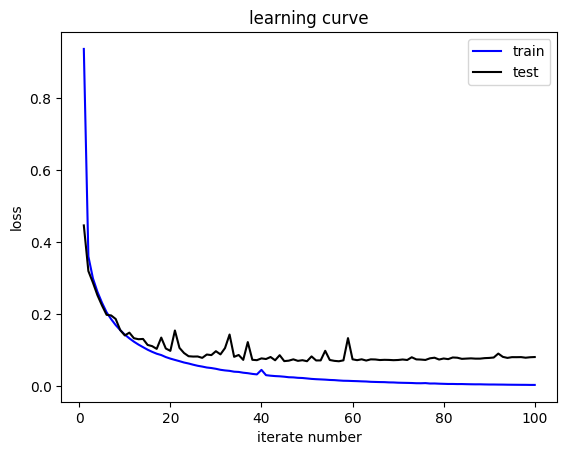

In [95]:
# 学習曲線の表示(損失)
plt.plot(history[:,0], history[:,1], "b", label="train")
plt.plot(history[:,0], history[:,3], "k", label="test")
plt.xlabel('iterate number')
plt.ylabel('loss')
plt.title('learning curve')
plt.legend()
plt.show()

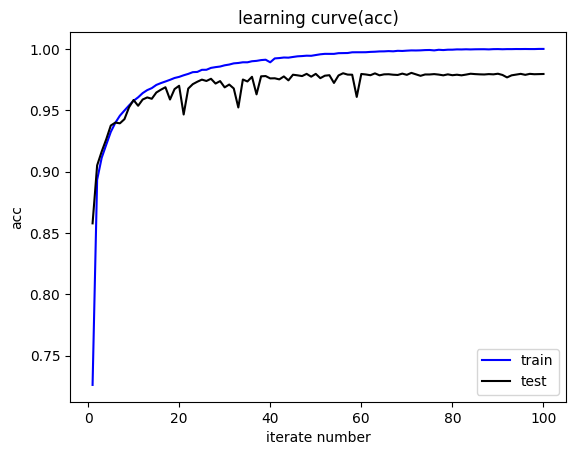

In [96]:
# 学習曲線の表示(精度)
plt.plot(history[:,0], history[:,2], "b", label="train")
plt.plot(history[:,0], history[:,4], "k", label="test")
plt.xlabel('iterate number')
plt.ylabel('acc')
plt.title('learning curve(acc)')
plt.legend()
plt.show()